In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
# import cv2
from PIL import Image
import os
import seaborn as sns
import random as rand
import math
import umap
from mpl_toolkits.mplot3d import Axes3D

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
SEED = 1

# Python built-in random
rand.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch (if applicable)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
    super().__init__(path, train, download = True)
    self.n_classes = 10
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output), label

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [5]:
Trainset = Dataset('./data')
Testset = Dataset('./data', train=False)

## EDA

In [6]:
# Get the list of class names
class_names = Trainset.classes

# Print the mapping from numerical labels to string labels
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

idx_to_class = {idx: class_name for idx, class_name in enumerate(class_names)}

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [7]:
train_labels_list = [idx_to_class[item] for item in Trainset.targets]
val_labels_list = [idx_to_class[item] for item in Testset.targets]

In [8]:
def show_imgs(masked_image, mask, original_image, label, title1 = "Masked Image", title2 = "Mask", title3 = "Original Image"):
  f, axs = plt.subplots(1,3)
  axs[0].imshow(np.transpose(masked_image.numpy(), (1,2,0)))
  axs[0].set_title(title1)
  axs[1].imshow(np.transpose(mask.numpy(), (1,2,0)))
  axs[1].set_title(title2)
  axs[2].imshow(np.transpose(original_image.numpy(), (1,2,0)))
  axs[2].set_title(title3)

  plt.suptitle( f" (Label: {idx_to_class[label]})", fontsize=14, y=0.7)
  plt.tight_layout(rect=[0, 0, 0.9, 0.88])  # leave space for the suptitle
  plt.show()

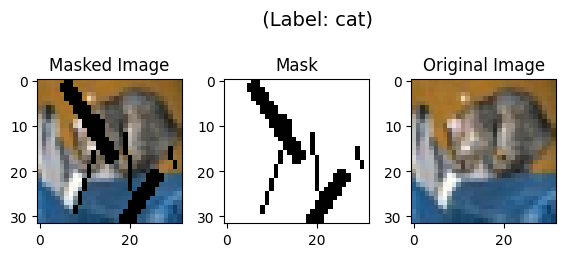

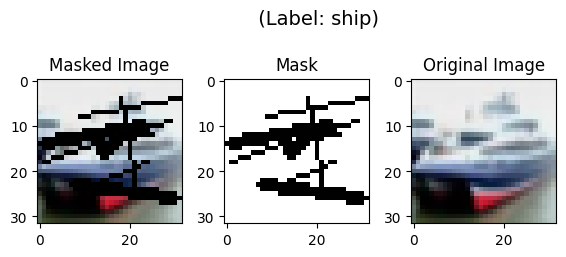

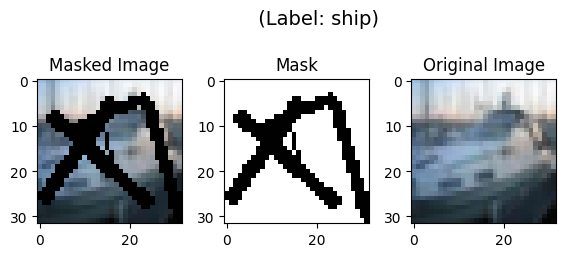

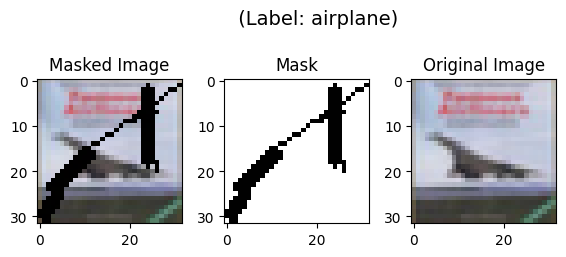

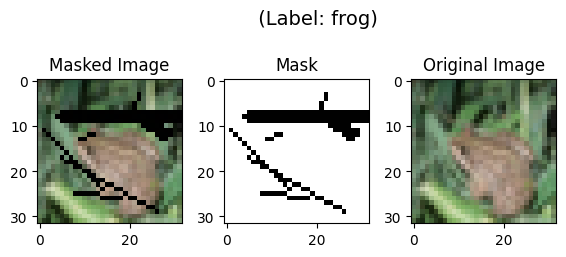

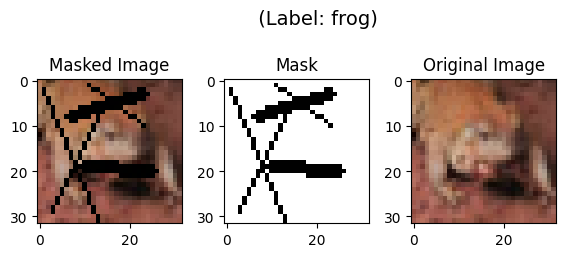

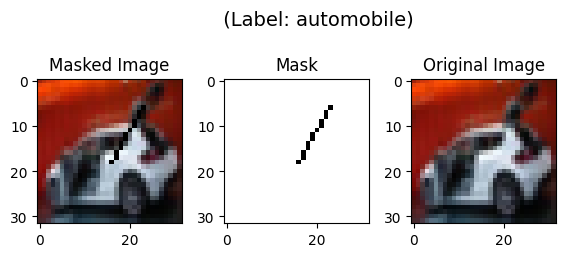

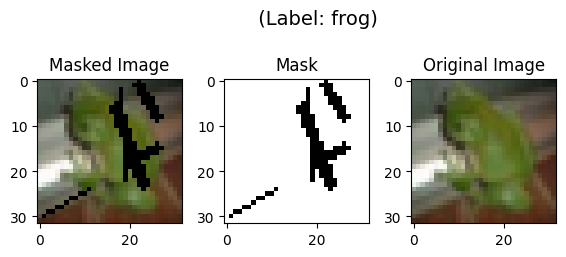

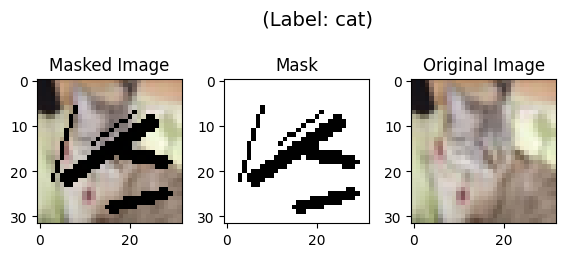

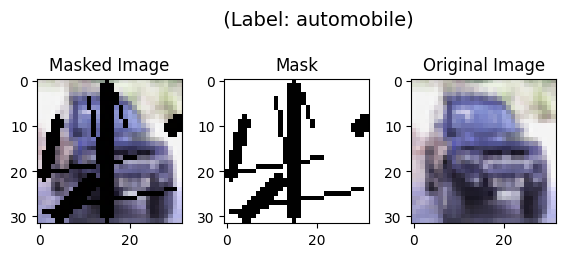

In [9]:
# 2. Randomly pick one image per class and display original, masked and recosntructed versions
# Build index lists
class_indices = {i: [] for i in class_names}
for idx, label in enumerate(val_labels_list):
    class_indices[label].append(idx)
# print(f"Selected indices for car: {class_indices['cat'][:10]} ...")
# print(f"Selected indices for airplane: {class_indices['airplane'][:10]} ...")
# Sample one per class
selected_indices = [(c, rand.choice(class_indices[c])) for c in class_names]
# print(selected_indices)
for i, (c, idx) in enumerate(selected_indices):
  # print(f"{i}) {c} ")
  masked_img, mask, orginal_img, label = Testset[i]
  show_imgs(masked_img, mask, orginal_img, label)

In [10]:
print("Train label distribution:")
print(Counter(train_labels_list))

print("Validation label distribution:")
print(Counter(val_labels_list))

Train label distribution:
Counter({'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000})
Validation label distribution:
Counter({'cat': 1000, 'ship': 1000, 'airplane': 1000, 'frog': 1000, 'automobile': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000})


In [11]:
print(f"Sample image sizes:")
for i in range(5):
    img_mask, mask, img_og, label = Trainset[i]
    print(f"Image {i}: Size_mask = {img_mask.size()}, size_og = {img_og.size()}")

Sample image sizes:
Image 0: Size_mask = torch.Size([3, 32, 32]), size_og = torch.Size([3, 32, 32])
Image 1: Size_mask = torch.Size([3, 32, 32]), size_og = torch.Size([3, 32, 32])
Image 2: Size_mask = torch.Size([3, 32, 32]), size_og = torch.Size([3, 32, 32])
Image 3: Size_mask = torch.Size([3, 32, 32]), size_og = torch.Size([3, 32, 32])
Image 4: Size_mask = torch.Size([3, 32, 32]), size_og = torch.Size([3, 32, 32])


## Analysis of shallow U-net like convolutional architecture for Denoising Autoencoder

In [12]:
batch_size = 128
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [13]:
# Get one batch from trainloader
data_iter = iter(Trainloader)
inputs, masks, targets, _ = next(data_iter)
#check dimensions match
print(f"Input batch shape: {inputs.shape}")
print(f"Mask batch shape: {masks.shape}")
print(f"Target batch shape: {targets.shape}")

Input batch shape: torch.Size([128, 3, 32, 32])
Mask batch shape: torch.Size([128, 3, 32, 32])
Target batch shape: torch.Size([128, 3, 32, 32])


In [ ]:
latent_dim = 128
middle_layer_maps_1 = 64
middle_layer_maps_2 = 128
final_layer_maps = 256
kern_size = 3
# def compute_size(x, kern_size):
#   return ((x + 2 - kern_size)//2 + 1)
# linear_size = compute_size(compute_size(middle_layer_maps_1,3), 3)
# print(f"size of hidden linear layer: {linear_size}")

In [ ]:
class Conv_AutoEncoder(nn.Module):
  def __init__(self):
      super(Conv_AutoEncoder, self).__init__()
      # Encoder
      self.encoder = nn.Sequential(
          nn.Conv2d(3, middle_layer_maps_1, kernel_size=3, stride=1, padding=1),  # 32*32
          nn.BatchNorm2d(middle_layer_maps_1),
          nn.ReLU(True),

          nn.MaxPool2d(kernel_size=2, stride=2),  # 32*32 to 16*16

          nn.Conv2d(middle_layer_maps_1, middle_layer_maps_2, kernel_size=3, stride=2, padding=1),  # 16*16 to 8*8
          nn.BatchNorm2d(middle_layer_maps_2),
          nn.ReLU(True),

          nn.Conv2d(middle_layer_maps_2, final_layer_maps, kernel_size=3, stride=2, padding=1),  # 8*8 to 4*4
          nn.BatchNorm2d(final_layer_maps),
          nn.ReLU(True),

          nn.Flatten(),
          nn.Linear(final_layer_maps * 4 * 4, latent_dim),
          nn.Tanh()
      )

      # Almost Symmetric Decoder
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, 256 * 4 * 4),
          nn.ReLU(),
          nn.Unflatten(1, (256, 4, 4)),

          nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4*4 to 8*8
          nn.BatchNorm2d(128),
          nn.ReLU(True),

          nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8*8 to 16*16
          nn.BatchNorm2d(64),
          nn.ReLU(True),

          nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),# Upsample to reverse MaxPool like in U-net model: 16*16 to 32*32
          nn.BatchNorm2d(64),
          nn.ReLU(True),

          nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # 32*32
          nn.Sigmoid()
      )

  def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [ ]:
#Training with MSE loss
model = Conv_AutoEncoder().to(device)
#DISPLAY MODEL
# Move model to device (usually CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Provide model input shape (excluding batch size)
summary(model, input_size=(3, 32, 32))

#DEFINE LOSS and OPTIMIZER
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# with learning rate 1e-3 optimizer convergence is fast,
# overshooting a little and then fluctuating around the minimum

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
       BatchNorm2d-6            [-1, 128, 8, 8]             256
              ReLU-7            [-1, 128, 8, 8]               0
            Conv2d-8            [-1, 256, 4, 4]         295,168
       BatchNorm2d-9            [-1, 256, 4, 4]             512
             ReLU-10            [-1, 256, 4, 4]               0
          Flatten-11                 [-1, 4096]               0
           Linear-12                  [-1, 128]         524,416
             Tanh-13                  [-1, 128]               0
           Linear-14                 [-

In [16]:
#store loss
training_loss = []

num_epochs = 20 #at least 15 for 1e-4 learning rate
for epoch in range(num_epochs):
  model.train()
  tot_loss = 0
  for corrupt_imgs, _ , true_imgs, _ in Trainloader:
    true_imgs = true_imgs.to(device)
    corrupt_imgs = corrupt_imgs.to(device)

    # Forward pass
    outputs = model(corrupt_imgs)
    loss = criterion(outputs, true_imgs)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tot_loss += loss.item()

  #save loss for later use
  training_loss.append(tot_loss/len(Trainloader))
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss = {(tot_loss/len(Trainloader)):.4f}")

Epoch [1/20], Loss = 0.0232
Epoch [2/20], Loss = 0.0141
Epoch [3/20], Loss = 0.0125
Epoch [4/20], Loss = 0.0116
Epoch [5/20], Loss = 0.0109
Epoch [6/20], Loss = 0.0103
Epoch [7/20], Loss = 0.0097
Epoch [8/20], Loss = 0.0094
Epoch [9/20], Loss = 0.0090
Epoch [10/20], Loss = 0.0088
Epoch [11/20], Loss = 0.0085
Epoch [12/20], Loss = 0.0084
Epoch [13/20], Loss = 0.0081
Epoch [14/20], Loss = 0.0080
Epoch [15/20], Loss = 0.0079
Epoch [16/20], Loss = 0.0077
Epoch [17/20], Loss = 0.0076
Epoch [18/20], Loss = 0.0074
Epoch [19/20], Loss = 0.0074
Epoch [20/20], Loss = 0.0073


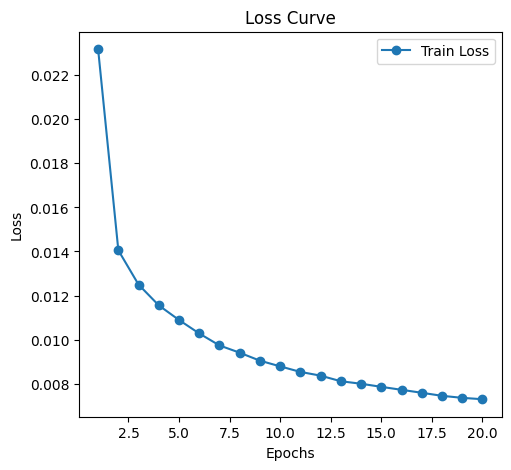

In [17]:
# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, (num_epochs+1)), training_loss, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

## MODEL EVALAUTION ON TEST SET

In [19]:
#model perfrmance on test set
model.eval()

mse_total = 0
psnr_total = 0
n = 0

with torch.no_grad():
    for img_mask, _, img_true, _ in Testloader:
        inputs = img_mask.to(device)
        outputs = model(inputs)
        # Accumulate metrics
        mse = F.mse_loss(outputs, img_true.to(device), reduction='mean')

        # PSNR calculation
        psnr = 10 * torch.log10(1.0 / mse)

        #update totals
        mse_total += mse.item()
        psnr_total += psnr.item()
        n+=1

# Final averages
print(f"Validation MSE:  {mse_total / n:.10f}")
print(f"Validation PSNR: {psnr_total / n:.5f} dB")

Validation MSE:  0.0071345540
Validation PSNR: 21.47125 dB


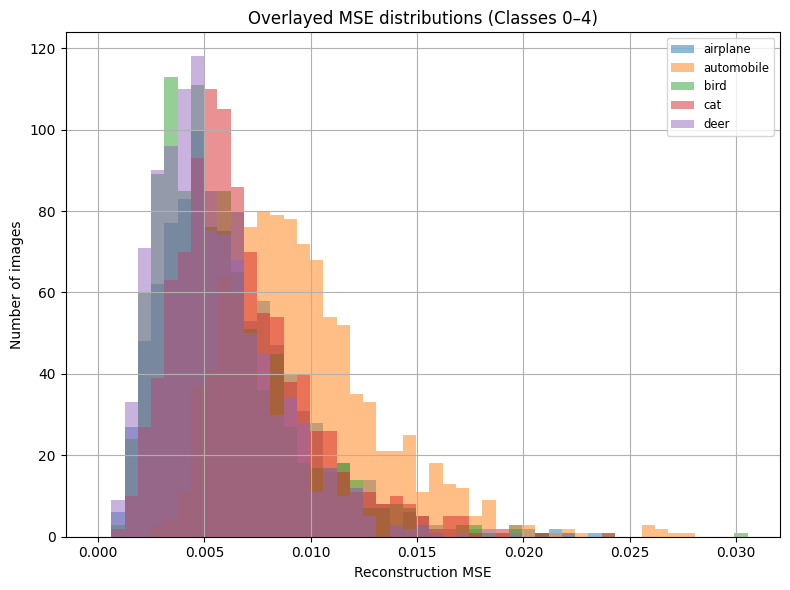

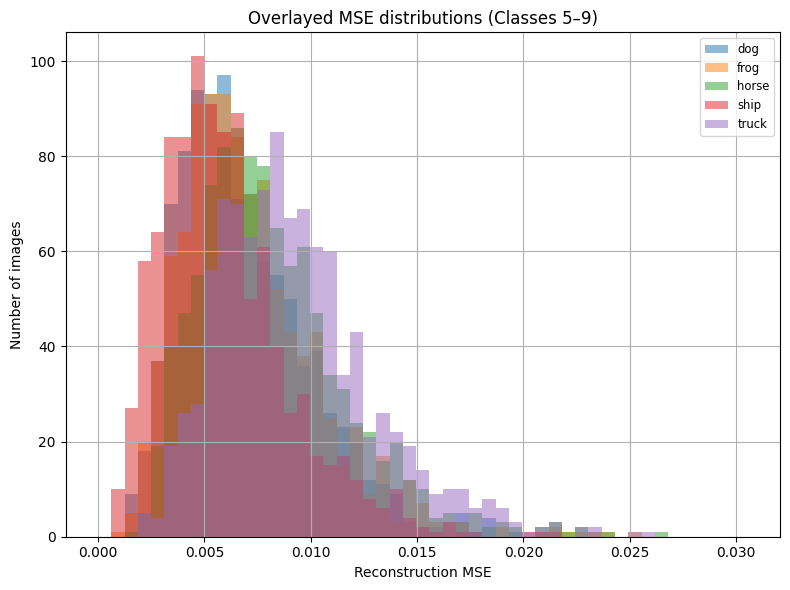

In [20]:
# Compute per-sample MSEs by class
model.eval()
mse_by_class = {i: [] for i in range(10)}

with torch.no_grad():
    for masked_imgs, _, og_img, labels in Testloader:
        corr_imgs = masked_imgs.to(device)
        og_img = og_img.to(device)
        recon = model(corr_imgs)
        batch_mse = F.mse_loss(recon, og_img, reduction='none') \
                       .view(masked_imgs.size(0), -1).mean(dim=1)
        for mse_val, lbl in zip(batch_mse.cpu().numpy(), labels.numpy()):
            mse_by_class[lbl].append(mse_val)

# Set bins globally for consistency across histograms
all_mse_values = [mse for lst in mse_by_class.values() for mse in lst]
bins = np.linspace(0, max(all_mse_values), 50)

# Plot 2 separate histograms of MSE for 5 classes each
for group in [(0, 5), (5, 10)]:
    plt.figure(figsize=(8, 6))
    for cls_idx in range(group[0], group[1]):
        plt.hist(mse_by_class[cls_idx], bins=bins, alpha=0.5, label=class_names[cls_idx])
    plt.xlabel("Reconstruction MSE")
    plt.ylabel("Number of images")
    plt.title(f"Overlayed MSE distributions (Classes {group[0]}–{group[1] - 1})")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

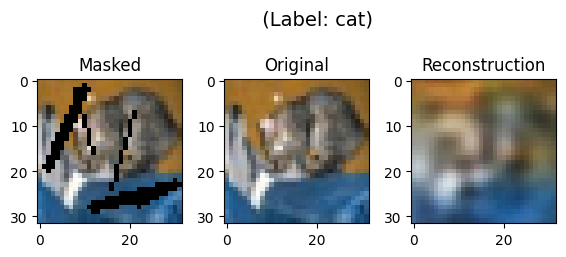

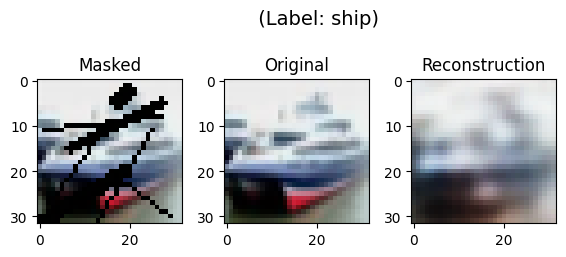

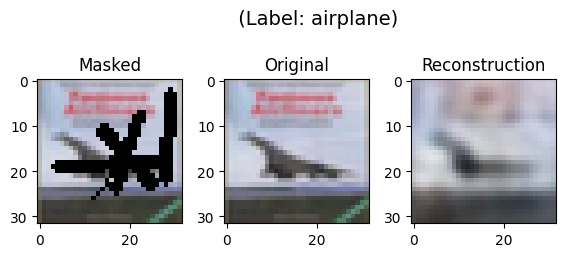

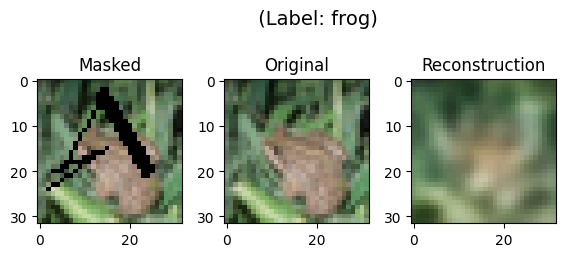

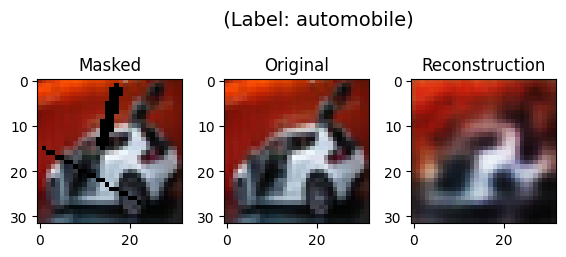

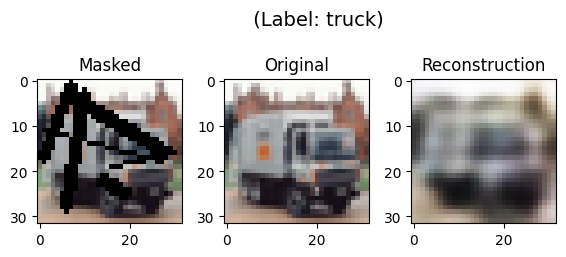

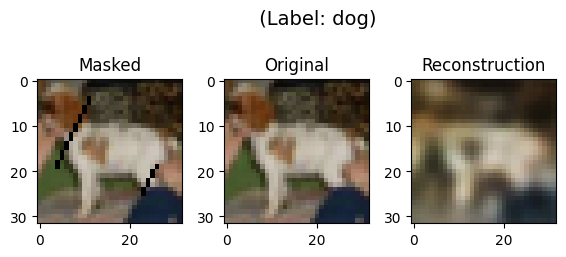

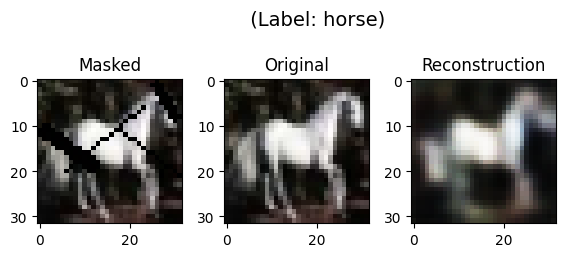

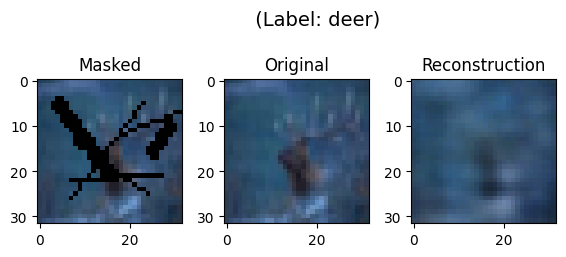

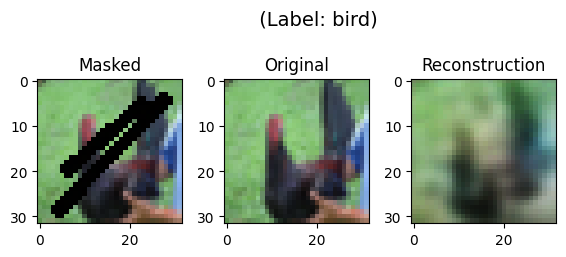

In [21]:
model.eval()
# Store one image per class
images_per_class = {}
images_mask_per_class = {}
reconstructions_per_class = {}

with torch.no_grad():
    for img_mask, _, img_true, label in Testloader:
        img_mask, img_true, label = img_mask.to(device), img_true.to(device), label.to(device)
        outputs = model(img_mask)

        for i in range(len(label)):
            class_id = label[i].item()
            if class_id not in images_per_class:
                images_per_class[class_id] = img_true[i].cpu()
                images_mask_per_class[class_id] = img_mask[i].cpu()
                reconstructions_per_class[class_id] = outputs[i].cpu()
            if len(images_per_class) == 10:
                break
        if len(images_per_class) == 10:
                break
for label in images_per_class.keys():
  show_imgs(images_mask_per_class[label], images_per_class[label], reconstructions_per_class[label], label,
            title1="Masked", title2="Original", title3="Reconstruction")

## UMAP VISUALISATION OF ORIGINAL and LATENT SPACE

100%|██████████| 170M/170M [00:21<00:00, 7.99MB/s] 
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


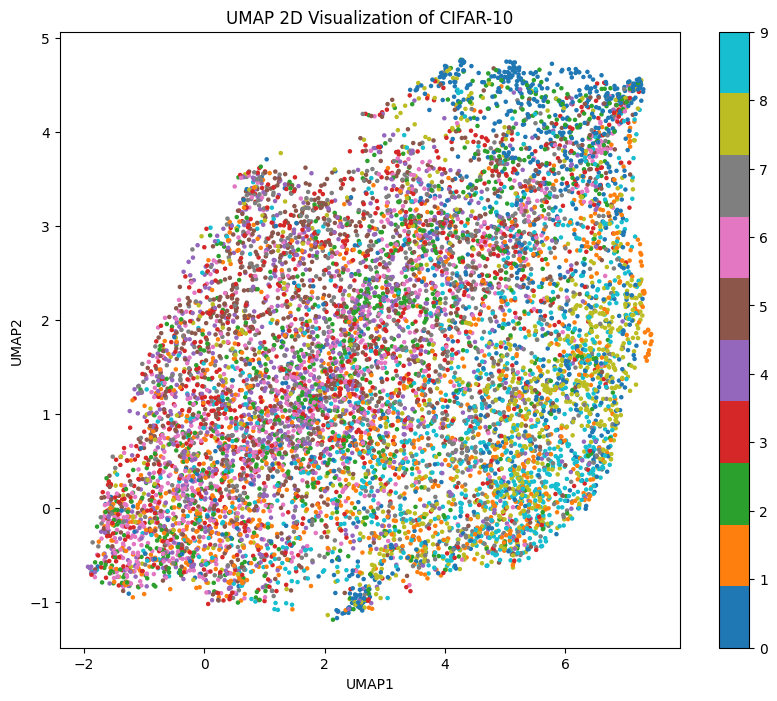

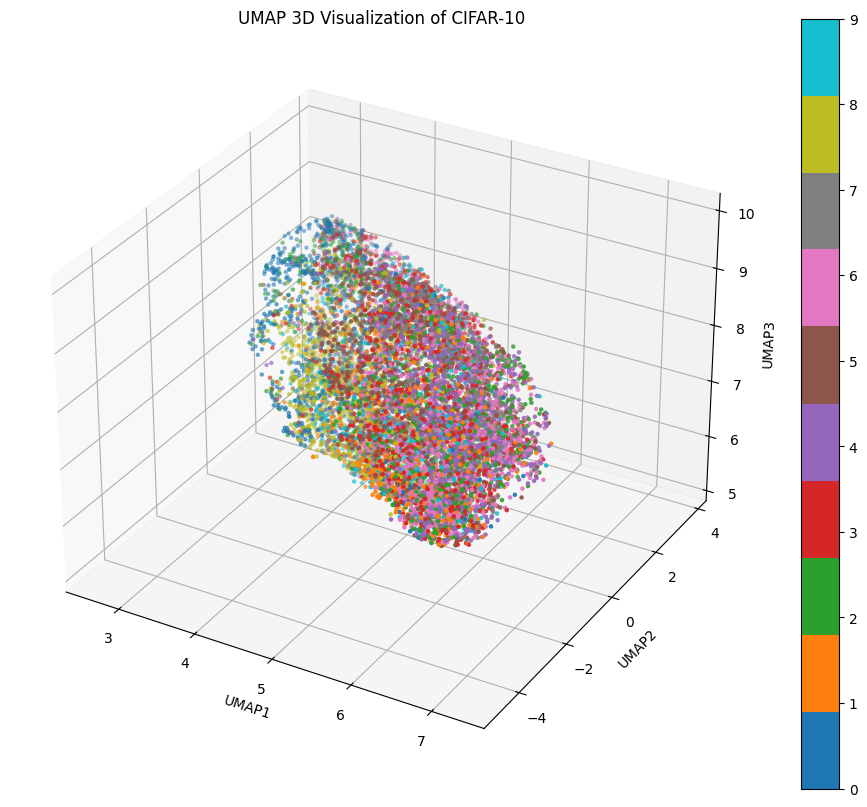

In [ ]:
# Load CIFAR-10 dataset normally to get images and labels
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar_10', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(cifar10, batch_size=1000, shuffle=False)

# Extract all images and labels from the dataset
images_list = []
labels_list = []

for imgs, labels in loader:
    images_list.append(imgs)
    labels_list.append(labels)

images = torch.cat(images_list)  # shape [N, 3, 32, 32]
labels = torch.cat(labels_list)  # shape [N]

# Flatten images 
features = images.view(images.size(0), -1).numpy()  # shape [N, 3*32*32]

# Run UMAP for 2D
reducer_2d = umap.UMAP(n_components=2)
embedding_2d = reducer_2d.fit_transform(features)

# Run UMAP for 3D
reducer_3d = umap.UMAP(n_components=3)
embedding_3d = reducer_3d.fit_transform(features)

# Plot 2D embedding
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP 2D Visualization of CIFAR-10')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# Plot 3D embedding
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=labels, cmap='tab10', s=5)
fig.colorbar(p, ticks=range(10))
ax.set_title('UMAP 3D Visualization of CIFAR-10')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


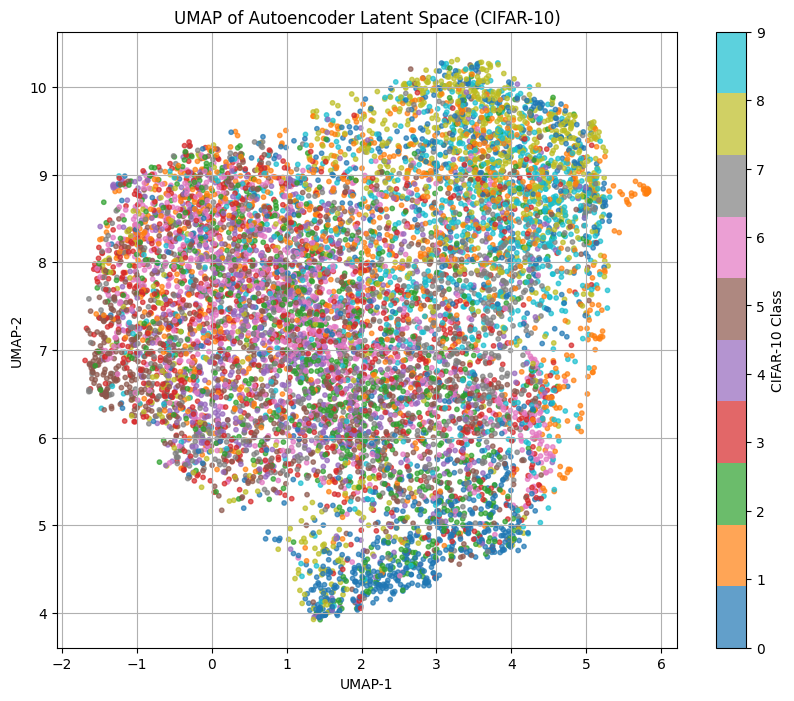

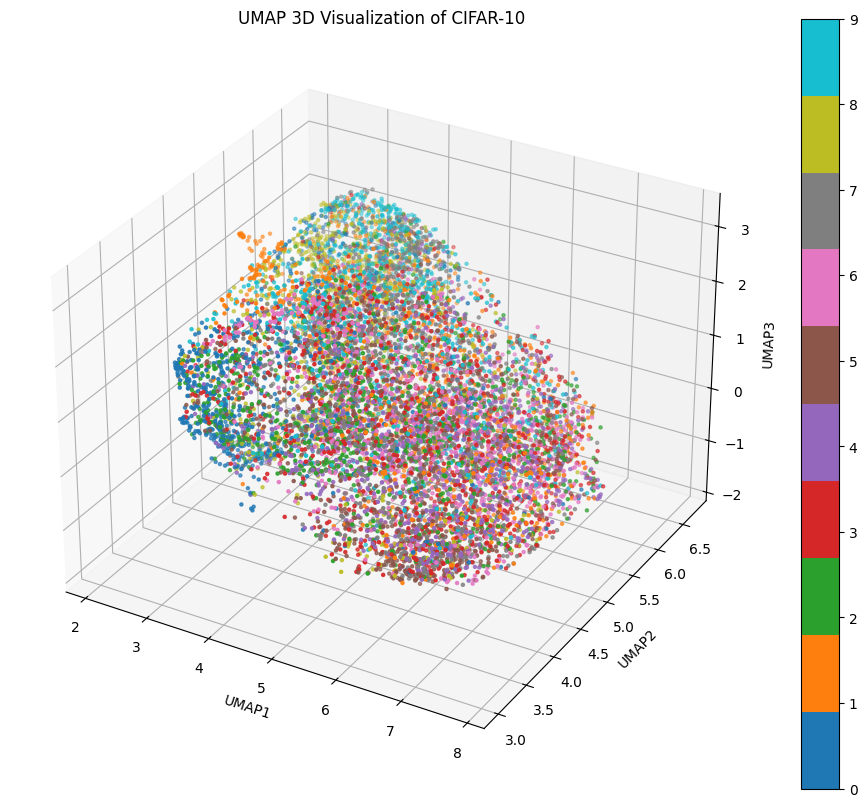

In [ ]:
# Ensure model is in evaluation mode
model.eval()

# Extract latent features and labels
latent_features = []
labels = []

with torch.no_grad():
    for masked_images, _, _, classes in Testloader:
        # Move to appropriate device if necessary
        masked_images = masked_images.to(next(model.parameters()).device)

        # Get latent representation
        latent = model.encoder(masked_images)  # endode the images
        latent = latent.view(latent.size(0), -1)  # flatten 

        latent_features.append(latent.cpu().numpy())
        labels.extend(classes.numpy())

# Combine all batches
latent_features = np.concatenate(latent_features, axis=0)
labels = np.array(labels)

# UMAP dimensionality reduction
reducer = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = reducer.fit_transform(latent_features)

# Run UMAP for 3D
reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding_3d = reducer_3d.fit_transform(latent_features)

# Plot UMAP projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='CIFAR-10 Class')
plt.title("UMAP of Autoencoder Latent Space (CIFAR-10)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# Plot 3D embedding
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=labels, cmap='tab10', s=5)
fig.colorbar(p, ticks=range(10))
ax.set_title('UMAP 3D Visualization of CIFAR-10')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.show()